# Deep Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|
|Michal Reszka-Gniecki|Ckires|michalreszkagniecki|

## Table of Contents
- [Data Overview](#data-overview)
- [Exploratory Data Analysis](#exploratory-data-analysis)
    - [Visualiseren](#visualiseren)
- [Feature Engineering](#feature-engineering)
    - [Analysis](#analysis)
- [Modeling](#modeling)
    - [Objectdetectie](#Model1)
    - [Ondertiteling van afbeeldinge](#Model2)
    - [Beeldgeneratie](#Model3)
    - [Implementatie](#Model4)
- [Results](#results)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)
- [Submission functie](#Submission-functie)
- [HTML functie](#HTML-functie)

In [2]:
# !pip install keras-tuner --upgrade
# !pip install wordcloud
# !pip install tqdm
# !pip install ultralytics

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import random
import torch
import glob
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Overview

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data importeren

In [ ]:
img_train = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Train"
img_test = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test"


In [ ]:
sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Portfolio 3 Datasets/submission_example.csv')

## Exploratory Data Analysis

#### Train data

In [ ]:
# ImageDataGenerator aanmaken
datagen = ImageDataGenerator(rescale=1./255)  # normaliseer de beelden

# Laad de data automatisch uit submappen
train_data = datagen.flow_from_directory(
    img_train,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", train_data.class_indices)

Found 2145 images belonging to 2 classes.
Klassen en hun indexen: {'images': 0, 'labels': 1}


#### Test data

In [ ]:
test_data = datagen.flow_from_directory(
    img_test,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
print("Klassen en hun indexen:", test_data.class_indices)


Found 537 images belonging to 1 classes.
Klassen en hun indexen: {'images': 0}


## Voorbeeld afbeeldingen

### Train afbeeldingen

In [ ]:
def toon_afbeeldingen_uit_batch(data, num_images):
    """
    Toont een aantal afbeeldingen uit een batch van een ImageDataGenerator.

    Parameters:
    - data: de ImageDataGenerator (flow_from_directory)
    - num_images: het aantal afbeeldingen om te tonen
    """
    # Haal een batch op
    images, labels = next(data)

    # Plot de afbeeldingen
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


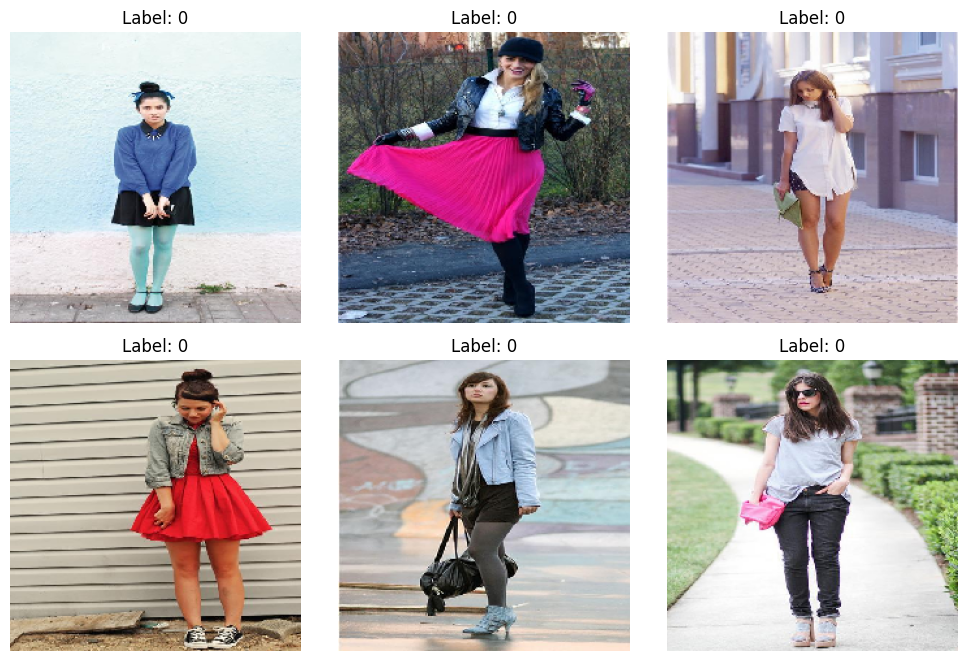

In [ ]:
train_data_show = toon_afbeeldingen_uit_batch(train_data, 6)

### Test afbeeldingen

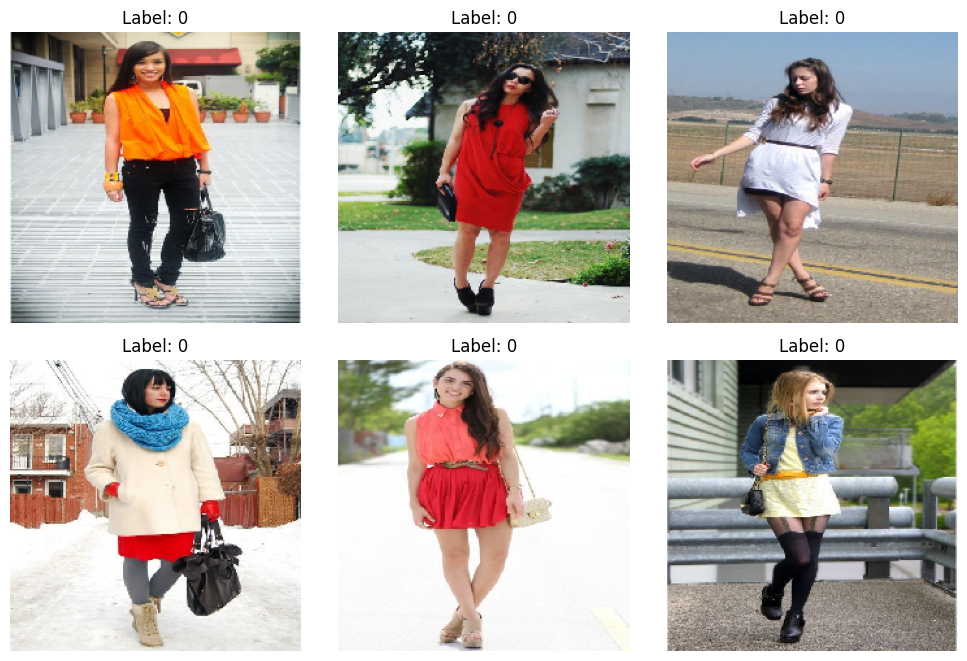

In [ ]:
test_data_show = toon_afbeeldingen_uit_batch(test_data,6)

## Breedte & Hoogte verdeling

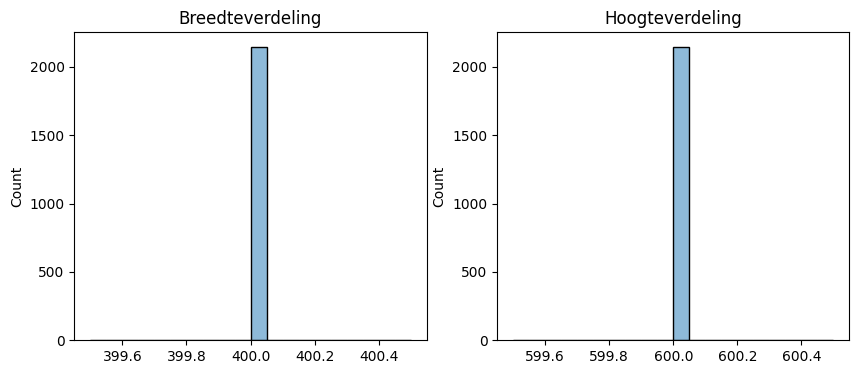

In [ ]:
def verzamel_afmetingen(data):
    sizes = []
    for label in os.listdir(data):
        label_path = os.path.join(data, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(label_path, img_name)
                    try:
                        with Image.open(img_path) as img:
                            sizes.append(img.size)
                    except:
                        continue
    return sizes

afmetingen = verzamel_afmetingen(img_train)

# Visualiseer

widths = [s[0] for s in afmetingen]
heights = [s[1] for s in afmetingen]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(widths, bins=20, kde=True)
plt.title("Breedteverdeling")

plt.subplot(1, 2, 2)
sns.histplot(heights, bins=20, kde=True)
plt.title("Hoogteverdeling")
plt.show()



De histogrammen laten zien dat bijna alle objecten precies dezelfde breedte en hoogte hebben. De breedte is altijd 400 eenheden en de hoogte is altijd 600 eenheden. Er is vrijwel geen verschil tussen de objecten, want de pieken in de histogrammen zijn heel scherp en geconcentreerd op die waarden.

Dit betekent dat de dataset erg uniform is. Mogelijk zijn de objecten bewust zo gemaakt of geselecteerd met vaste afmetingen, bijvoorbeeld omdat de afbeeldingen allemaal hetzelfde formaat hebben. Het ontbreken van variatie in breedte en hoogte is opvallend en kan invloed hebben op hoe een model leert, omdat het weinig verschillende vormen ziet.

## Controle op corrupte afbeeldingen

In [ ]:
def controleer_corruptie(data):
    fouten = []
    for root, dirs, files in os.walk(data):
        for name in files:
            if name.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, name)
                with Image.open(path) as img:
                        img.verify()

    return fouten

corrupt = controleer_corruptie(img_train)
print(f"Corrupt of onleesbare afbeeldingen gevonden: {len(corrupt)}")


Corrupt of onleesbare afbeeldingen gevonden: 0


De code controleert of er beschadigde of onleesbare afbeeldingen in de dataset zitten. Het resultaat geeft aan dat er geen corrupte afbeeldingen zijn gevonden. Dit betekent dat alle beelden goed leesbaar en bruikbaar zijn voor verdere verwerking.

## Voorbeeldbeelden met kleurverdeling

In [ ]:
images_dir = img_train + '/images'

In [ ]:
def toon_images_met_histogram(map_pad, aantal):
    # Pak alle afbeelding-bestanden in de map
    image_files = [f for f in os.listdir(map_pad) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # if len(image_files) < aantal:
    #     print(f"Niet genoeg afbeeldingen in de map ({len(image_files)} gevonden, {aantal} gevraagd).")
    #     return

    # Kies random aantal afbeeldingen
    gekozen = random.sample(image_files, aantal)

    plt.figure(figsize=(12, 4 * aantal))

    for i, fname in enumerate(gekozen):
        path = os.path.join(map_pad, fname)
        img = cv2.imread(path)
        # if img is None:
        #     print(f"Kan {fname} niet laden!")
        #     continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        r, g, b = cv2.split(img)

        # Toon afbeelding
        plt.subplot(aantal, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')

        # Toon histogram
        plt.subplot(aantal, 2, i*2 + 2)
        plt.hist(r.ravel(), bins=256, color='r', alpha=0.5, label='Rood')
        plt.hist(g.ravel(), bins=256, color='g', alpha=0.5, label='Groen')
        plt.hist(b.ravel(), bins=256, color='b', alpha=0.5, label='Blauw')
        plt.title("RGB Histogram")
        plt.xlabel("Pixelwaarde")
        plt.ylabel("Aantal pixels")
        plt.legend()

    plt.tight_layout()
    plt.show()


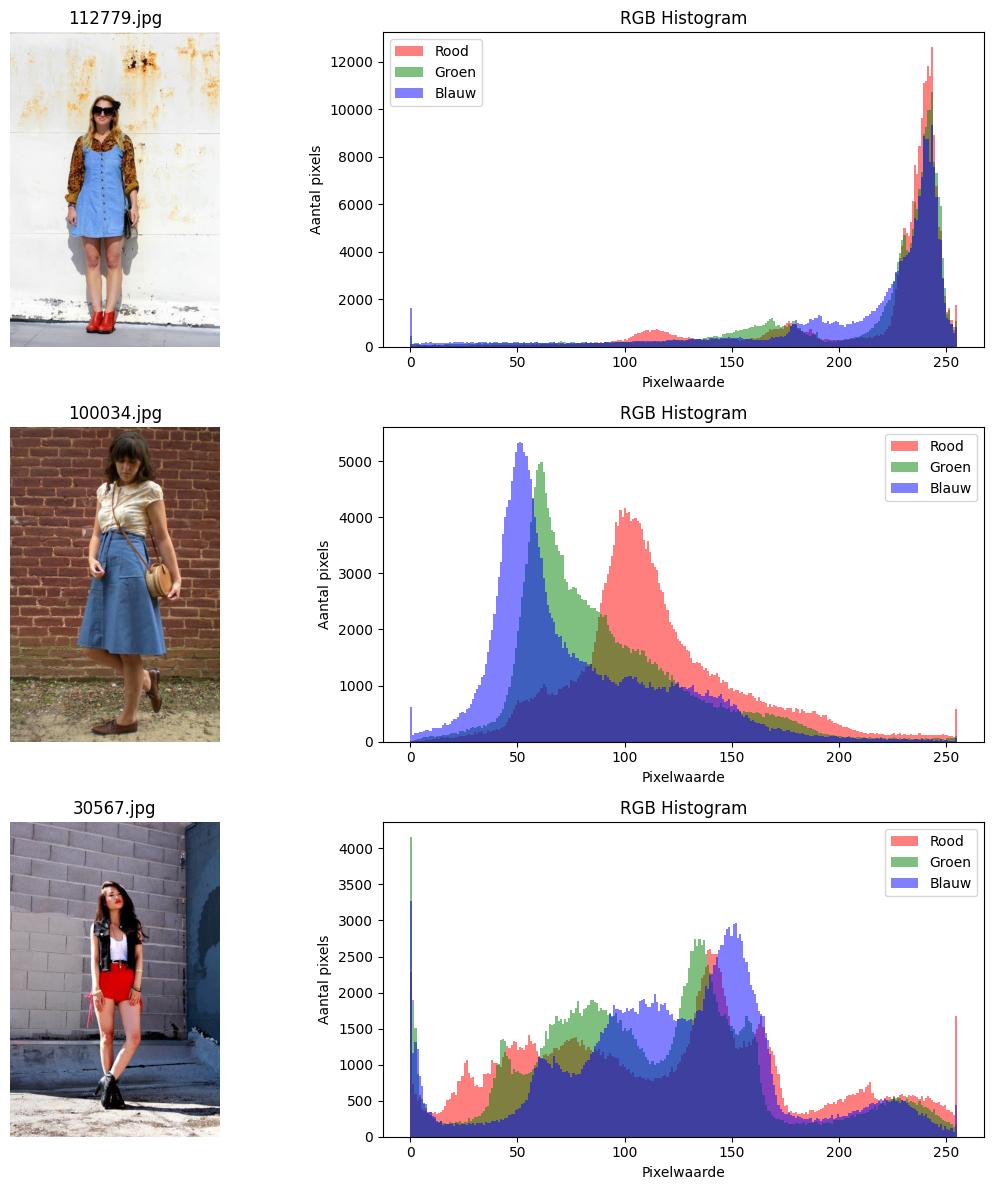

In [ ]:
toon_images_met_histogram(images_dir, 3)


De kleuren verschillen sterk per afbeelding. Dit zie je ook terug in de RGB-histogrammen. Elke afbeelding heeft een andere verdeling van rood, groen en blauw.

Sommige foto's hebben veel heldere kleuren zoals geel en groen, terwijl andere juist warme tinten bevatten zoals rood en bruin. Ook de hoeveelheid licht en schaduw speelt een rol.

De histogrammen laten zien welke kleuren het meest aanwezig zijn in de afbeelding. Hoge pieken in één kleur betekenen dat die kleur veel voorkomt. Als de pieken van rood en groen overlappen, zie je bijvoorbeeld veel geel.

De kleurverdeling is niet altijd gelijk. Elke afbeelding heeft zijn eigen sfeer en dominante kleuren, en dat zie je goed terug in de histogrammen. Dit kan invloed hebben op het model, omdat het model kleuren gebruikt als visuele informatie om objecten te herkennen. Grote kleurverschillen kunnen ervoor zorgen dat het model sommige objecten beter of juist slechter leert herkennen.

### Afbeeldingen met labels

In [ ]:
def toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, aantal):
    # Kies willekeurige afbeeldingen
    alle_afbeeldingen = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    gekozen_afbeeldingen = random.sample(alle_afbeeldingen, min(aantal, len(alle_afbeeldingen)))

    plt.figure(figsize=(6 * aantal, 6))

    for idx, gekozen_afb in enumerate(gekozen_afbeeldingen):
        naam_zonder_ext = os.path.splitext(gekozen_afb)[0]
        label_pad = os.path.join(labels_dir, f"{naam_zonder_ext}.txt")
        image_pad = os.path.join(images_dir, gekozen_afb)

        # Laad de afbeelding
        img = cv2.imread(image_pad)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Lees labelbestand en teken bounding boxes
        if os.path.exists(label_pad):
            with open(label_pad, 'r') as f:
                for line in f:
                    delen = line.strip().split()
                    class_id = int(delen[0])
                    cx, cy, bw, bh = map(float, delen[1:])

                    x1 = int((cx - bw / 2) * w)
                    y1 = int((cy - bh / 2) * h)
                    x2 = int((cx + bw / 2) * w)
                    y2 = int((cy + bh / 2) * h)

                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, class_dict[class_id], (x1, y1 - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Plot afbeelding
        plt.subplot(1, aantal, idx + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(gekozen_afb)

    plt.tight_layout()
    plt.show()

# Klassen
class_dict = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}




In [ ]:
labels_dir = img_train + '/labels'


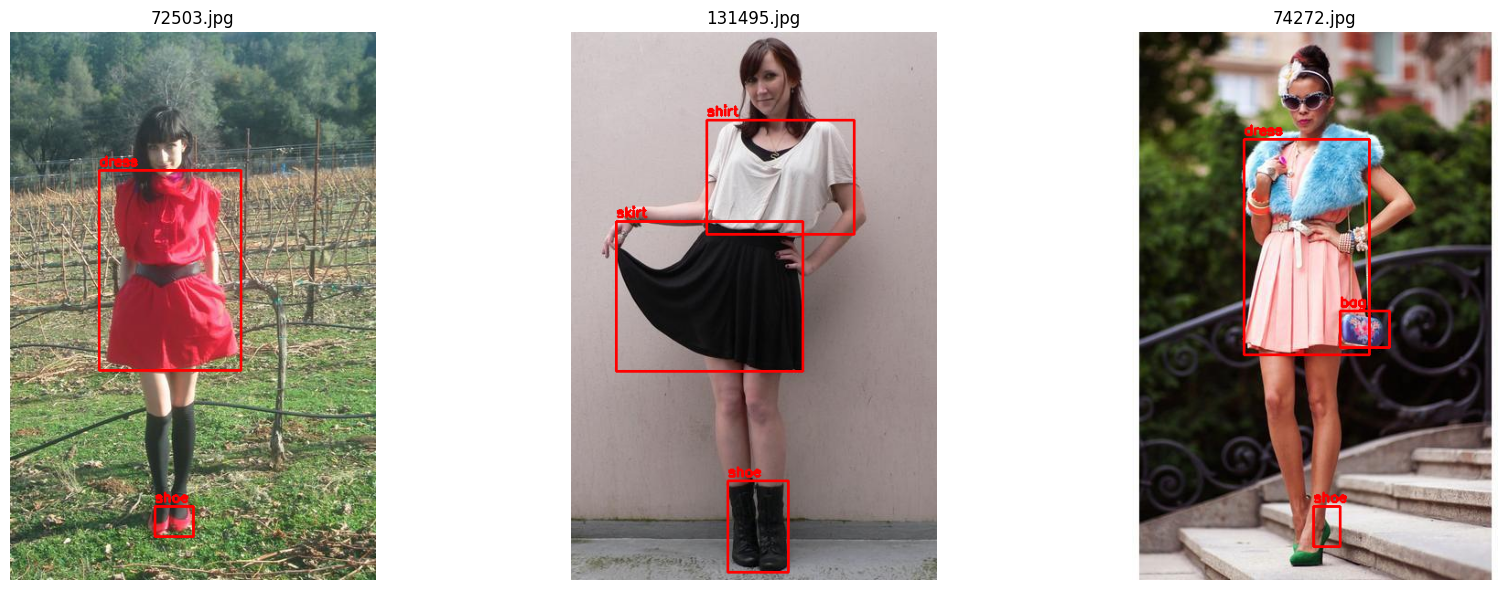

In [ ]:
toon_meerdere_afbeeldingen_met_bboxes(images_dir, labels_dir, class_dict, 3)

De labels zijn over het algemeen goed gedaan voor de kledingstukken en accessoires. De meeste objecten zijn duidelijk en correct gelabeld. Maar bij de schoenen is dat wat minder goed gegaan. Sommige schoenen zijn niet goed zichtbaar op de afbeelding of zijn niet helemaal juist gelabeld.

Dat kan een probleem zijn voor het model. Als de schoenen niet goed gelabeld zijn, wordt het voor het model moeilijker om te leren wat een schoen precies is. Hierdoor kan het model minder goed schoenen herkennen tijdens het testen. Dit kan de nauwkeurigheid van het model negatief beïnvloeden, vooral voor de klasse "schoen", ook al is dat de meest voorkomende klasse in de dataset.

Het is dus belangrijk om ook bij veelvoorkomende klassen te zorgen voor goede en duidelijke labels, zodat het model betrouwbare resultaten kan geven.

### De klassenverdeling in de labels

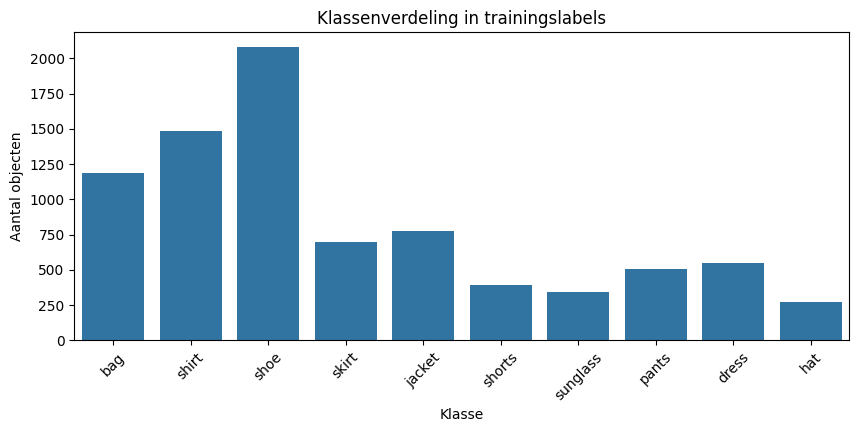

In [ ]:
def analyseer_klassenverdeling(label_dir):
    counter = Counter()
    for lbl in os.listdir(label_dir):
        if lbl.endswith(".txt"):
            with open(os.path.join(label_dir, lbl), 'r') as f:
                for line in f:
                    class_id = int(line.strip().split()[0])
                    counter[class_id] += 1
    return counter


verdeling = analyseer_klassenverdeling(labels_dir)

# Visualiseren
plt.figure(figsize=(10, 4))
sns.barplot(x=[class_dict[k] for k in verdeling.keys()], y=list(verdeling.values()))
plt.title("Klassenverdeling in trainingslabels")
plt.ylabel("Aantal objecten")
plt.xlabel("Klasse")
plt.xticks(rotation=45)
plt.show()


De staafdiagram laat zien hoe de objectklassen verdeeld zijn in de trainingslabels. Op de x-as staan de klassen en op de y-as het aantal objecten per klasse.

Schoenen komen het meest voor, met meer dan 2000 objecten. Daarna komen shirts met ongeveer 1500 objecten, gevolgd door tassen met 1200. Jassen en rokken hebben elk tussen de 700 en 800 objecten. Broeken en jurken hebben ongeveer 500 objecten. Korte broeken en zonnebrillen zijn minder vaak aanwezig, met ongeveer 350 en 300 objecten. Hoeden komen het minst voor, iets meer dan 250 keer.

De staafdiagram laat duidelijk zien dat de verdeling van klassen ongelijk is. Dit noemen we een ongebalanceerde dataset. Dat kan invloed hebben op het trainen van een model. Het model leert dan beter de veelvoorkomende klassen te herkennen en minder goed de zeldzame.

## Feature Engineering

## Modeling

### Objectdetectie

In [ ]:
import os
import shutil
import random

random.seed(42)

# Originele train folders
images_dir = f"{img_train}/images"
labels_dir = f"{img_train}/labels"

dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/'
# Nieuwe mappen voor split
train_images_dir = f'{dir}train/images'
train_labels_dir = f'{dir}train/labels'
val_images_dir = f'{dir}val/images'
val_labels_dir = f'{dir}val/labels'

os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Alle afbeeldingen in train
all_images = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle en split 80% train, 20% val
random.shuffle(all_images)
split_idx = int(len(all_images)*0.8)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

# Functie om bestanden te kopiëren
def copy_files(file_list, src_images, src_labels, dst_images, dst_labels):
    for file_name in file_list:
        # kopieer afbeelding
        shutil.copy(os.path.join(src_images, file_name), os.path.join(dst_images, file_name))
        # kopieer label (zelfde naam maar .txt extensie)
        label_name = os.path.splitext(file_name)[0] + '.txt'
        shutil.copy(os.path.join(src_labels, label_name), os.path.join(dst_labels, label_name))

# Kopieer train bestanden
copy_files(train_images, images_dir, labels_dir, train_images_dir, train_labels_dir)
# Kopieer val bestanden
copy_files(val_images, images_dir, labels_dir, val_images_dir, val_labels_dir)


In [ ]:
# if not os.path.exists('yolov5'):
#     !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Total 17483 (delta 0), reused 0 (delta 0), pack-reused 17483 (from 1)
Receiving objects: 100% (17483/17483), 16.58 MiB | 27.13 MiB/s, done.
Resolving deltas: 100% (11991/11991), done.


In [ ]:
# Installeer dependencies van YOLOv5 (alleen nodig bij eerste keer)
# %cd yolov5
# !pip install -r requirements.txt
# %cd ..


/content/yolov5
/content


In [ ]:
# Pad naar het data.yaml bestand in de Colab-omgeving
yaml_file_path = '/content/data.yaml'

# Inhoud van het data.yaml bestand
yaml_content = """
train: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/train/images
val: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/val/images


nc: 10
names: ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']

"""

# Schrijf de inhoud naar het bestand
with open(yaml_file_path, 'w') as f:
    f.write(yaml_content)

print(f"'{yaml_file_path}' is aangepast.")

'/content/data.yaml' is aangepast.


In [ ]:
# !python /content/yolov5/train.py --data /content/data.yaml --weights yolov5m.pt --img 640 --epochs 50 --batch-size 32

In [ ]:
!python /content/yolov5/detect.py \
  --weights /content/yolov5/runs/train/exp/weights/best.pt \
  --source "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images" \
  --img 640 \
  --conf 0.25 \
  --save-txt \
  --project /content/yolov5/runs/detect \
  --name test_predictions \
  --exist-ok


python3: can't open file '/content/yolov5/detect.py': [Errno 2] No such file or directory


In [ ]:
import os
import glob
import torch
import pandas as pd
from PIL import Image


# Zoek automatisch het pad naar best.pt (laatste experiment)
runs_dir = '/content/yolov5/runs/train'
list_of_runs = glob.glob(f'{runs_dir}/exp*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# Laad het getrainde YOLOv5-model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=weights_path, force_reload=True)
model.eval()  # Belangrijk voor evaluatie (geen dropout, batchnorm in eval mode)

# Pad naar testafbeeldingen en output-CSV
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/submission.csv'

# Functie om voorspellingen te maken en te formatteren
def predict_model(image_path):
    results = model(image_path)
    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    if results.pred is not None and len(results.pred) > 0:
        for *box, conf, cls in results.pred[0].tolist():
            xmin, ymin, xmax, ymax = box
            cx = (xmin + xmax) / 2 / w_img
            cy = (ymin + ymax) / 2 / h_img
            bw = (xmax - xmin) / w_img
            bh = (ymax - ymin) / h_img
            preds.extend([
                int(cls),
                round(conf, 4),
                round(cx, 6),
                round(cy, 6),
                round(bw, 6),
                round(bh, 6)
            ])
    return preds

# Verwerk alle testafbeeldingen en maak predictions
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    # Formatteer als comma-separated string in lijstnotatie: [0,0.99,0.5,...]
    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    # Verwijder de extensie (.jpg) voor de id-kolom
    image_id = os.path.splitext(img_name)[0]

    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# Maak en exporteer de CSV
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-5-31 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 212 layers, 20889303 parameters, 0 gradients, 48.0 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/

Submission bestand opgeslagen in: /content/submission.csv


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

In [ ]:
# Pad naar jouw training run
results_csv_path1 = '/content/yolov5/runs/train/exp/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path1)

df.tail()

epoch     train/box_loss     train/obj_loss  \
45                 45           0.022053           0.025312   
46                 46           0.021721           0.025290   
47                 47           0.021394           0.025133   
48                 48           0.021204           0.024246   
49                 49           0.020929           0.024825   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
45           0.004646            0.79722  ...           0.036810   
46           0.004534            0.80641  ...           0.037603   
47           0.004483            0.78753  ...           0.037320   
48           0.004605            0.79421  ...           0.037391   
49           0.004349            0.80502  ...           0.037277   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
45           0.008673           0.001288           0.001288           0.001288  
46           0.008762           0.001090           0.001090           0.001090  
47           0.008938           0.000892           0.000892           0.000892  
48           0.009019           0.000694           0.000694           0.000694  
49           0.008830           0.000496           0.000496           0.000496  

[5 rows x 14 columns]

25 epochs

In [ ]:
# Pad naar jouw training run
results_csv_path = '/content/yolov5/runs/train/exp2/results.csv'

# Lees het bestand
df = pd.read_csv(results_csv_path)

df

epoch     train/box_loss     train/obj_loss  \
0                   0           0.083021           0.063074   
1                   1           0.062982           0.048551   
2                   2           0.060614           0.043917   
3                   3           0.053233           0.041145   
4                   4           0.047312           0.041063   
5                   5           0.044323           0.039697   
6                   6           0.041640           0.039658   
7                   7           0.040094           0.038000   
8                   8           0.038963           0.038233   
9                   9           0.037802           0.037513   
10                 10           0.036339           0.037181   
11                 11           0.036021           0.036083   
12                 12           0.035268           0.036777   
13                 13           0.033867           0.035971   
14                 14           0.033242           0.035409   
15                 15           0.032951           0.034902   
16                 16           0.031576           0.034442   
17                 17           0.030982           0.033313   
18                 18           0.030368           0.032720   
19                 19           0.029494           0.032578   
20                 20           0.028577           0.031599   
21                 21           0.028198           0.030996   
22                 22           0.027858           0.030998   
23                 23           0.027280           0.030589   
24                 24           0.026108           0.029812   

       train/cls_loss  metrics/precision  ...       val/obj_loss  \
0            0.052098            0.42729  ...           0.051379   
1            0.032132            0.47028  ...           0.034036   
2            0.025677            0.39751  ...           0.032999   
3            0.020788            0.46190  ...           0.031942   
4            0.017501            0.62073  ...           0.032653   
5            0.015065            0.63302  ...           0.034212   
6            0.013754            0.72570  ...           0.032997   
7            0.012406            0.72650  ...           0.032033   
8            0.012223            0.73050  ...           0.032354   
9            0.011545            0.72574  ...           0.032543   
10           0.010631            0.72216  ...           0.032612   
11           0.010633            0.75170  ...           0.032688   
12           0.010065            0.73521  ...           0.032786   
13           0.009579            0.76674  ...           0.032541   
14           0.009350            0.75021  ...           0.032054   
15           0.008923            0.75114  ...           0.031879   
16           0.008367            0.76203  ...           0.032593   
17           0.008206            0.74715  ...           0.032776   
18           0.007690            0.75059  ...           0.033081   
19           0.007427            0.76101  ...           0.033287   
20           0.007300            0.75660  ...           0.032377   
21           0.007267            0.76099  ...           0.032773   
22           0.006644            0.75753  ...           0.033500   
23           0.006636            0.77103  ...           0.032943   
24           0.006272            0.76332  ...           0.033328   

         val/cls_loss              x/lr0              x/lr1              x/lr2  
0            0.033125           0.070556           0.003272           0.003272  
1            0.022291           0.040294           0.006343           0.006343  
2            0.017266           0.009768           0.009151           0.009151  
3            0.013786           0.008812           0.008812           0.008812  
4            0.012121           0.008812           0.008812           0.008812  
5            0.011512           0.008416           0.008416           0.008416  
6            0.009950           0.008020 

### Ondertiteling van afbeeldinge

### Beeldgeneratie

### Implementatie

### Scoren:

|Model|Notebook|Kaggle|
|----|------|------|
||||
||||
||||
||||

#### Bevindingen modellen

## Conclusion & Advice

## Sources

### Submission functie

In [ ]:
def create_submission(pred, df_test, filename, label_encoder):
    """
    Creates a submission file for Kaggle test data with genre predictions.

    Args:
        pred (np.ndarray): Predicted probabilities or class indices.
        df_test (pd.DataFrame): Test dataframe containing filenames.
        filename (str): Output CSV filename (must include .csv).
        label_encoder (LabelEncoder): Trained label encoder to decode genre indices.

    Returns:
        pd.DataFrame: Submission dataframe.
    """
    # Als pred probabilities bevat → neem hoogste waarschijnlijkheid
    if pred.ndim > 1 and pred.shape[1] > 1:
        pred_classes = np.argmax(pred, axis=1)
    else:
        pred_classes = pred.reshape(-1)

    # Decode genre-namen
    genre_labels = label_encoder.inverse_transform(pred_classes[:len(df_test)])

    # Maak het submission DataFrame
    submission_df = pd.DataFrame({
        'filename': df_test['filename'].values[:len(genre_labels)],
        'genre': genre_labels
    })

    # Sla op
    submission_df.to_csv(filename, index=False)

    return submission_df


In [ ]:
# create_submission(y_pred, df_test, 'test.csv', le)

filename    genre
0    test.00000.wav     rock
1    test.00001.wav  country
2    test.00002.wav      pop
3    test.00003.wav    blues
4    test.00004.wav  country
..              ...      ...
124  test.00124.wav   reggae
125  test.00125.wav  country
126  test.00126.wav   hiphop
127  test.00127.wav  country
128  test.00128.wav      pop

[129 rows x 2 columns]

### Html

In [ ]:
# Upload ipynb
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")

Saving Portfolio_1.ipynb to Portfolio_1.ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test model

## Objectdetectie

Objectdetectie is een techniek waarbij neurale netwerken worden gebruikt om objecten in afbeeldingen te vinden en te herkennen. Deze vorm van computer vision wordt in veel gebieden toegepast, zoals in de medische beeldvorming en in zelfrijdende auto's [(Murel & Kavlakoglu, 2025)](https://www.ibm.com/think/topics/object-detection#:~:text=Object%20detection%20is%20a%20technique,imaging%20to%20self%2Ddriving%20cars.).


#### Hoe werkt objectdetectie?
Om objectdetectie te begrijpen, is basiskennis over digitale beeldverwerking nodig. Afbeeldingen worden omgezet naar pixels met bepaalde waarden. Door beelden te labelen in een trainingsset, leert een model patronen herkennen in vorm, kleur of grootte. Zo herkent het systeem objecten die lijken op wat het tijdens de training heeft gezien.

#### Modelarchitectuur
Objectdetectiemodellen bestaan meestal uit drie delen: de backbone (die kenmerken uit een afbeelding haalt), de neck (die deze kenmerken samenvoegt) en de head (die bepaalt waar objecten zijn en wat ze zijn). Er zijn twee soorten modellen: two-stage modellen (R-CNN) die eerst objecten vinden en dan classificeren, en one-stage modellen (YOLO) die dit in één keer doen.

#### Evaluatiemethoden
Een veelgebruikte manier om te meten hoe goed een model werkt, is met de Intersection over Union (IoU). Hierbij wordt gekeken hoeveel overlap er is tussen het voorspelde vak en het echte vak om een object. Hoe groter de overlap, hoe beter het model.

#### Algoritmes en architecturen
Er bestaan verschillende algoritmes voor objectdetectie. Een bekende familie is R-CNN, die nauwkeurig maar traag is. Snellere varianten zoals Fast en Faster R-CNN zijn later ontwikkeld. Een ander populair model is YOLO, dat objecten in één stap herkent en erg snel is. YOLO is daarom geschikt voor toepassingen in realtime. Nieuwere versies van deze modellen kunnen ook classificatie of segmentatie uitvoeren.

[(Murel & Kavlakoglu, 2025)](https://www.ibm.com/think/topics/object-detection#:~:text=Object%20detection%20is%20a%20technique,imaging%20to%20self%2Ddriving%20cars.)

#### Evaluatie van Objectdetectie
Belangrijke meetwaarden:

- mAP (mean Average Precision): meet hoe goed het model is in het vinden en benoemen van objecten.

- AP (Average Precision): meet de precisie per klasse.

- IoU (Intersection over Union): vergelijkt de overlap tussen voorspelde en echte vakjes.

Andere scores: TPR, FPR, F1-score, miss rate, en rekensnelheid.


 Voor deze opdracht gebruiken wij het YOLO-model als objectdetectiemodel.

 #### **YOLO(You Only Look Once)**
YOLO staat voor You Only Look Once en is een methode voor objectdetectie. In plaats van stap voor stap te zoeken naar objecten in een afbeelding, doet YOLO alles tegelijk. Het model gebruikt één neuraal netwerk om in één keer te voorspellen waar de objecten zijn en wat voor soort objecten het zijn.

YOLO werkt anders dan eerdere methodes zoals Faster R-CNN, die eerst stukjes van een afbeelding analyseren en daarna pas proberen te herkennen wat er te zien is. In tegenstelling tot die oudere methodes, die meerdere keren naar een afbeelding moeten kijken, heeft YOLO genoeg aan één keer.

Sinds de eerste versie in 2015 zijn er verschillende verbeterde versies van YOLO uitgebracht. Elke nieuwe versie maakt het model sneller en nauwkeuriger, waardoor het nu één van de populairste keuzes is voor real-time objectdetectie.


#### Hoe werkt YOLO?
YOLO gebruikt een convolutioneel neuraal netwerk (CNN) om objecten in een afbeelding te detecteren. Het model neemt een afbeelding als invoer en verdeelt die in een rooster (bijvoorbeeld 7x7 vakjes). Als het midden van een object in een bepaald vak valt, dan is dat vak verantwoordelijk voor het herkennen van het object.

Elke vakje voorspelt meerdere rechthoeken (bounding boxes) en bijbehorende scores. Die scores geven aan hoe zeker het model is dat er een object in zit en hoe goed de vorm past. Tijdens de training wordt maar één van die bounding boxes gebruikt om het object echt te voorspellen die met de beste overlap (IoU) met de juiste locatie. Zo leert elk voorspeller zich te specialiseren in een bepaald type object of vorm.

YOLO voorspelt tegelijk de locatie en de soort object met één volledig verbonden laag (fully connected layer). Deze laag komt na een reeks van 20 convolutionele lagen, die eerst zijn voorgetraind op het ImageNet-dataset. Daardoor herkent het model basisvormen al goed voordat het leert objecten te vinden.

#### **Non-maximum suppression(NMS)**
Een belangrijke stap in de verwerking is non-maximum suppression (NMS). Dit zorgt ervoor dat als er meerdere vakken hetzelfde object herkennen (met verschillende rechthoeken), er uiteindelijk maar één vakkeuze overblijft – degene met de hoogste score. NMS helpt zo om dubbele voorspellingen te verwijderen en de nauwkeurigheid te verhogen.

Nieuwe versies van YOLO hebben deze aanpak telkens verbeterd. Ze zorgen voor betere prestaties en nauwkeuriger herkenning, zonder de snelheid te verliezen die YOLO zo sterk maakt.

 [(Kundu, z.d.)](https://www.v7labs.com/blog/yolo-object-detection).

#### **Evaluatie**
YOLO-modellen worden geëvalueerd met:


1. **Precision** (nauwkeurigheid):

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

2. **Recall** (herkenningsgraad):

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

3. **Average Precision (AP):**  
De oppervlakte onder de precision-recall-curve voor één klasse.

4. **mAP (mean Average Precision):**  
Het gemiddelde van de AP-scores over alle klassen:

$$
\text{mAP} = \frac{1}{N} \sum_{i=1}^{N} AP_i
$$

**Legenda:**

- \( TP \): True Positives  
- \( FP \): False Positives  
- \( FN \): False Negatives  
- \( $N$ \): Aantal klassen  
- \( $AP_i$ \): Average Precision van klasse *i*


### IoU (Intersection over Union)

**IoU** meet de overlap tussen de voorspelde bounding box en de grondwaarheid (ground truth).

$$
\text{IoU} = \frac{\text{Oppervlakte van de Overlap}}{\text{Oppervlakte van de Unie}} = \frac{|A \cap B|}{|A \cup B|}
$$

Waarbij:

- \( $A$ \) = voorspelde bounding box  
- \( $B$ \) = ground-truth bounding box  
- \( $A \cap B$ \) = overlappende gebied van A en B  
- \( $A \cup B$ \) = gecombineerde gebied van A en B

**Interpretatie:**

- \( $\text{IoU} = 1$ \): perfecte overlap  
- \( $\text{IoU} = 0$ \): geen overlap  
- Typisch wordt een voorspelling als correct (True Positive) beschouwd als \( $\text{IoU} \geq 0.5$ \)

IoU wordt vaak gebruikt als drempel in objectdetectie om te bepalen of een voorspelde box als juist wordt beschouwd.

[(Rahmadsadli, 2023)](https://machinelearningspace.com/intersection-over-union-iou-a-comprehensive-guide/)


[(“Mean Average Precision (mAP) in Object Detection”, 2023)](https://www.superannotate.com/blog/mean-average-precision-and-its-uses-in-object-detection)


Er zijn meerdere verschillende versies van YOLO. Elke nieuwe versie bracht verbeteringen in snelheid, nauwkeurigheid of gebruiksgemak. Zo werd YOLO steeds beter in het herkennen van objecten in afbeeldingen of video. Nieuwere versies, zoals YOLOv8, YOLOv10 en YOLOv11, kunnen zelfs verschillende taken tegelijk uitvoeren, zoals detectie, segmentatie en classificatie.

[(Boesch, 2025)](https://viso.ai/computer-vision/yolo-explained/)

In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/'


In [ ]:
import albumentations as A
import cv2
import os
from glob import glob
import numpy as np

data_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/'

# Functie om augmentaties uit te voeren op een dataset
def augment_dataset(image_folder, label_folder, aug_image_folder, aug_label_folder, n_aug=7):
    os.makedirs(aug_image_folder, exist_ok=True)
    os.makedirs(aug_label_folder, exist_ok=True)

    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4),
        A.Affine(scale=(0.8, 1.2), p=0.5),
        A.Rotate(limit=10, p=0.3),
        A.RandomScale(scale_limit=0.2, p=0.3),
        A.Blur(blur_limit=3, p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    image_paths = sorted(glob(f'{image_folder}/*.jpg'))

    for img_path in image_paths:
        image = cv2.imread(img_path)
        name = os.path.basename(img_path).replace('.jpg', '')
        label_path = os.path.join(label_folder, f"{name}.txt")

        if not os.path.exists(label_path):
            print(f" Label ontbreekt voor {name}, overslaan...")
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()
            bboxes = []
            class_labels = []
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x, y, w, h = map(float, parts)
                bboxes.append([x, y, w, h])
                class_labels.append(int(cls))

        clipped_bboxes = []
        for bbox in bboxes:
            x_center, y_center, width, height = bbox
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2

            x_min = np.clip(x_min, 0.0, 1.0)
            y_min = np.clip(y_min, 0.0, 1.0)
            x_max = np.clip(x_max, 0.0, 1.0)
            y_max = np.clip(y_max, 0.0, 1.0)

            new_x_center = (x_min + x_max) / 2
            new_y_center = (y_min + y_max) / 2
            new_width = x_max - x_min
            new_height = y_max - y_min

            clipped_bboxes.append([new_x_center, new_y_center, new_width, new_height])

        for i in range(n_aug):
            augmented = augmentations(image=image, bboxes=clipped_bboxes, class_labels=class_labels)

            aug_img = augmented['image']
            aug_boxes = augmented['bboxes']
            aug_labels = augmented['class_labels']

            new_img_name = f"{name}_aug{i}.jpg"
            new_img_path = os.path.join(aug_image_folder, new_img_name)
            cv2.imwrite(new_img_path, aug_img)

            new_label_name = f"{name}_aug{i}.txt"
            new_label_path = os.path.join(aug_label_folder, new_label_name)
            with open(new_label_path, 'w') as f:
                for cls, box in zip(aug_labels, aug_boxes):
                    if box[2] > 0 and box[3] > 0:
                        box_str = ' '.join(f'{coord:.6f}' for coord in box)
                        f.write(f"{cls} {box_str}\n")

    print(f"✅ Offline augmentatie voltooid voor map: {image_folder}")

In [ ]:
# Augmentatie voor train
augment_dataset(
    image_folder=os.path.join(data_dir, 'train/images'),
    label_folder=os.path.join(data_dir, 'train/labels'),
    aug_image_folder=os.path.join(data_dir, 'train/images'),
    aug_label_folder=os.path.join(data_dir, 'train/labels'),
    n_aug=10
)


✅ Offline augmentatie voltooid voor map: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/train/images


In [ ]:
# Augmentatie voor val
augment_dataset(
    image_folder=os.path.join(data_dir, 'val/images'),
    label_folder=os.path.join(data_dir, 'val/labels'),
    aug_image_folder=os.path.join(data_dir, 'val/images'),
    aug_label_folder=os.path.join(data_dir, 'val/labels'),
)


✅ Offline augmentatie voltooid voor map: /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images


In [ ]:
def remove_augmented_files(folder_path, pattern='_aug'):
    removed_files = 0
    for file_path in glob(os.path.join(folder_path, f'*{pattern}*')):
        os.remove(file_path)
        removed_files += 1
    print(f"🗑️ Verwijderd: {removed_files} bestanden in {folder_path}")


In [ ]:
remove_augmented_files(os.path.join(data_dir, 'val/images'))
remove_augmented_files(os.path.join(data_dir, 'val/labels'))


🗑️ Verwijderd: 0 bestanden in /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images
🗑️ Verwijderd: 0 bestanden in /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/labels


In [ ]:
# import shutil
# import glob
# import os

# data_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/'
# aug_img_dir = os.path.join(data_dir, 'train/images_augmented')
# aug_lbl_dir = os.path.join(data_dir, 'train/labels_augmented')
# train_img_dir = os.path.join(data_dir, 'train/images')
# train_lbl_dir = os.path.join(data_dir, 'train/labels')

# # Verplaats augmented afbeeldingen naar originele mappen
# for file in glob.glob(f'{aug_img_dir}/*.jpg'):
#     shutil.move(file, os.path.join(train_img_dir, os.path.basename(file)))

# for file in glob.glob(f'{aug_lbl_dir}/*.txt'):
#     shutil.move(file, os.path.join(train_lbl_dir, os.path.basename(file)))

# print("Augmented data samengevoegd met originele training set.")


In [3]:
import yaml

data_yaml = {
    'train': '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/train/images',
    'val': '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images',
    'nc': 10,
    'names': ['sunglass','hat','jacket','shirt','pants','shorts','skirt','dress','bag','shoe']
}

with open('/content/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("data.yaml opgeslagen.")


✅ data.yaml opgeslagen.


In [6]:
from pathlib import Path
# Output folder voor trainingsresultaten
project_path = Path(data_dir) / 'runs'
project_path.mkdir(parents=True, exist_ok=True)

In [9]:
# !pip install ultralytics

In [10]:
from ultralytics import YOLO
from pathlib import Path

# Laad het model
model = YOLO('yolov8n.pt')

# Start training
model.train(
    data='/content/data.yaml',
    epochs=20,
    imgsz=640,
    batch=16,
    project='/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs',
    name='clothing_model',
    exist_ok=True,
    workers=8
)


Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=clothing_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0,

train: Scanning /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/train/labels.cache... 18876 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18876/18876 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.7±0.5 ms, read: 39.8±21.5 MB/s, size: 58.5 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/labels.cache... 3432 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3432/3432 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.36G      1.339      1.807      1.326         70        640: 100%|██████████| 1180/1180 [02:25<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:15<00:00,  6.96it/s]


                   all       3432      13307      0.648      0.707      0.707      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.36G      1.227      1.146      1.244         77        640: 100%|██████████| 1180/1180 [01:54<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.21it/s]


                   all       3432      13307      0.649      0.708      0.713      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.38G      1.193       1.01      1.226         67        640: 100%|██████████| 1180/1180 [01:51<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.26it/s]


                   all       3432      13307      0.682      0.732      0.728       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.39G      1.158     0.9259      1.207        113        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.20it/s]


                   all       3432      13307      0.717      0.743      0.751      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.39G      1.117      0.855      1.182        108        640: 100%|██████████| 1180/1180 [01:51<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.20it/s]


                   all       3432      13307      0.708      0.738      0.751      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.39G      1.079     0.7964      1.161         72        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:15<00:00,  7.17it/s]


                   all       3432      13307      0.705      0.753      0.743      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.39G       1.05      0.755      1.145         79        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:15<00:00,  7.14it/s]

                   all       3432      13307      0.734      0.751      0.759      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.39G      1.021     0.7182      1.127        106        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.25it/s]

                   all       3432      13307      0.728      0.731      0.745       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.39G      0.996     0.6895      1.114        118        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.51it/s]


                   all       3432      13307      0.736      0.747      0.757      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.39G     0.9679      0.661      1.099         92        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.37it/s]


                   all       3432      13307      0.721       0.75      0.746      0.493
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.39G     0.8857     0.5269      1.058         45        640: 100%|██████████| 1180/1180 [01:50<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.30it/s]


                   all       3432      13307      0.735      0.731      0.738      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.39G     0.8501     0.4947      1.031         46        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.28it/s]


                   all       3432      13307      0.729      0.738      0.738      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.39G     0.8232     0.4719      1.017         42        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.24it/s]

                   all       3432      13307      0.751      0.745      0.747      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.41G      0.791     0.4469     0.9992         48        640: 100%|██████████| 1180/1180 [01:49<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:15<00:00,  7.14it/s]

                   all       3432      13307      0.741      0.752      0.752      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.41G     0.7634      0.429     0.9828         39        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.46it/s]


                   all       3432      13307       0.76      0.736      0.748      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.41G      0.739     0.4089     0.9693         53        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.34it/s]


                   all       3432      13307      0.762      0.736      0.749      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.41G     0.7142     0.3937     0.9564         47        640: 100%|██████████| 1180/1180 [01:49<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.44it/s]


                   all       3432      13307      0.751      0.748      0.752      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.41G      0.689     0.3789     0.9447         45        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.27it/s]

                   all       3432      13307       0.75      0.746      0.751      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.41G     0.6659     0.3649     0.9351         47        640: 100%|██████████| 1180/1180 [01:48<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


                   all       3432      13307      0.746      0.748      0.745      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.41G     0.6519     0.3565     0.9277         47        640: 100%|██████████| 1180/1180 [01:49<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


                   all       3432      13307      0.747      0.746      0.744      0.487

20 epochs completed in 0.706 hours.
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/last.pt, 6.3MB
Optimizer stripped from /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt, 6.3MB

Validating /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 108/108 [00:16<00:00,  6.49it/s]


                   all       3432      13307      0.735      0.747      0.757      0.495
              sunglass        520        520      0.453      0.238      0.296     0.0976
                   hat        487        487      0.691      0.733       0.74      0.364
                jacket       1224       1272      0.753      0.834      0.815      0.629
                 shirt       2368       2440      0.768      0.828      0.838      0.571
                 pants        880        880      0.913      0.943      0.967      0.763
                shorts        616        616      0.772      0.685      0.694      0.444
                 skirt       1128       1128      0.713      0.893      0.829      0.614
                 dress        808        808      0.769      0.772      0.817      0.626
                   bag       1840       1840      0.749      0.737      0.766      0.409
                  shoe       3316       3316      0.773      0.808      0.808      0.437
Speed: 0.1ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ad4b8da9d90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

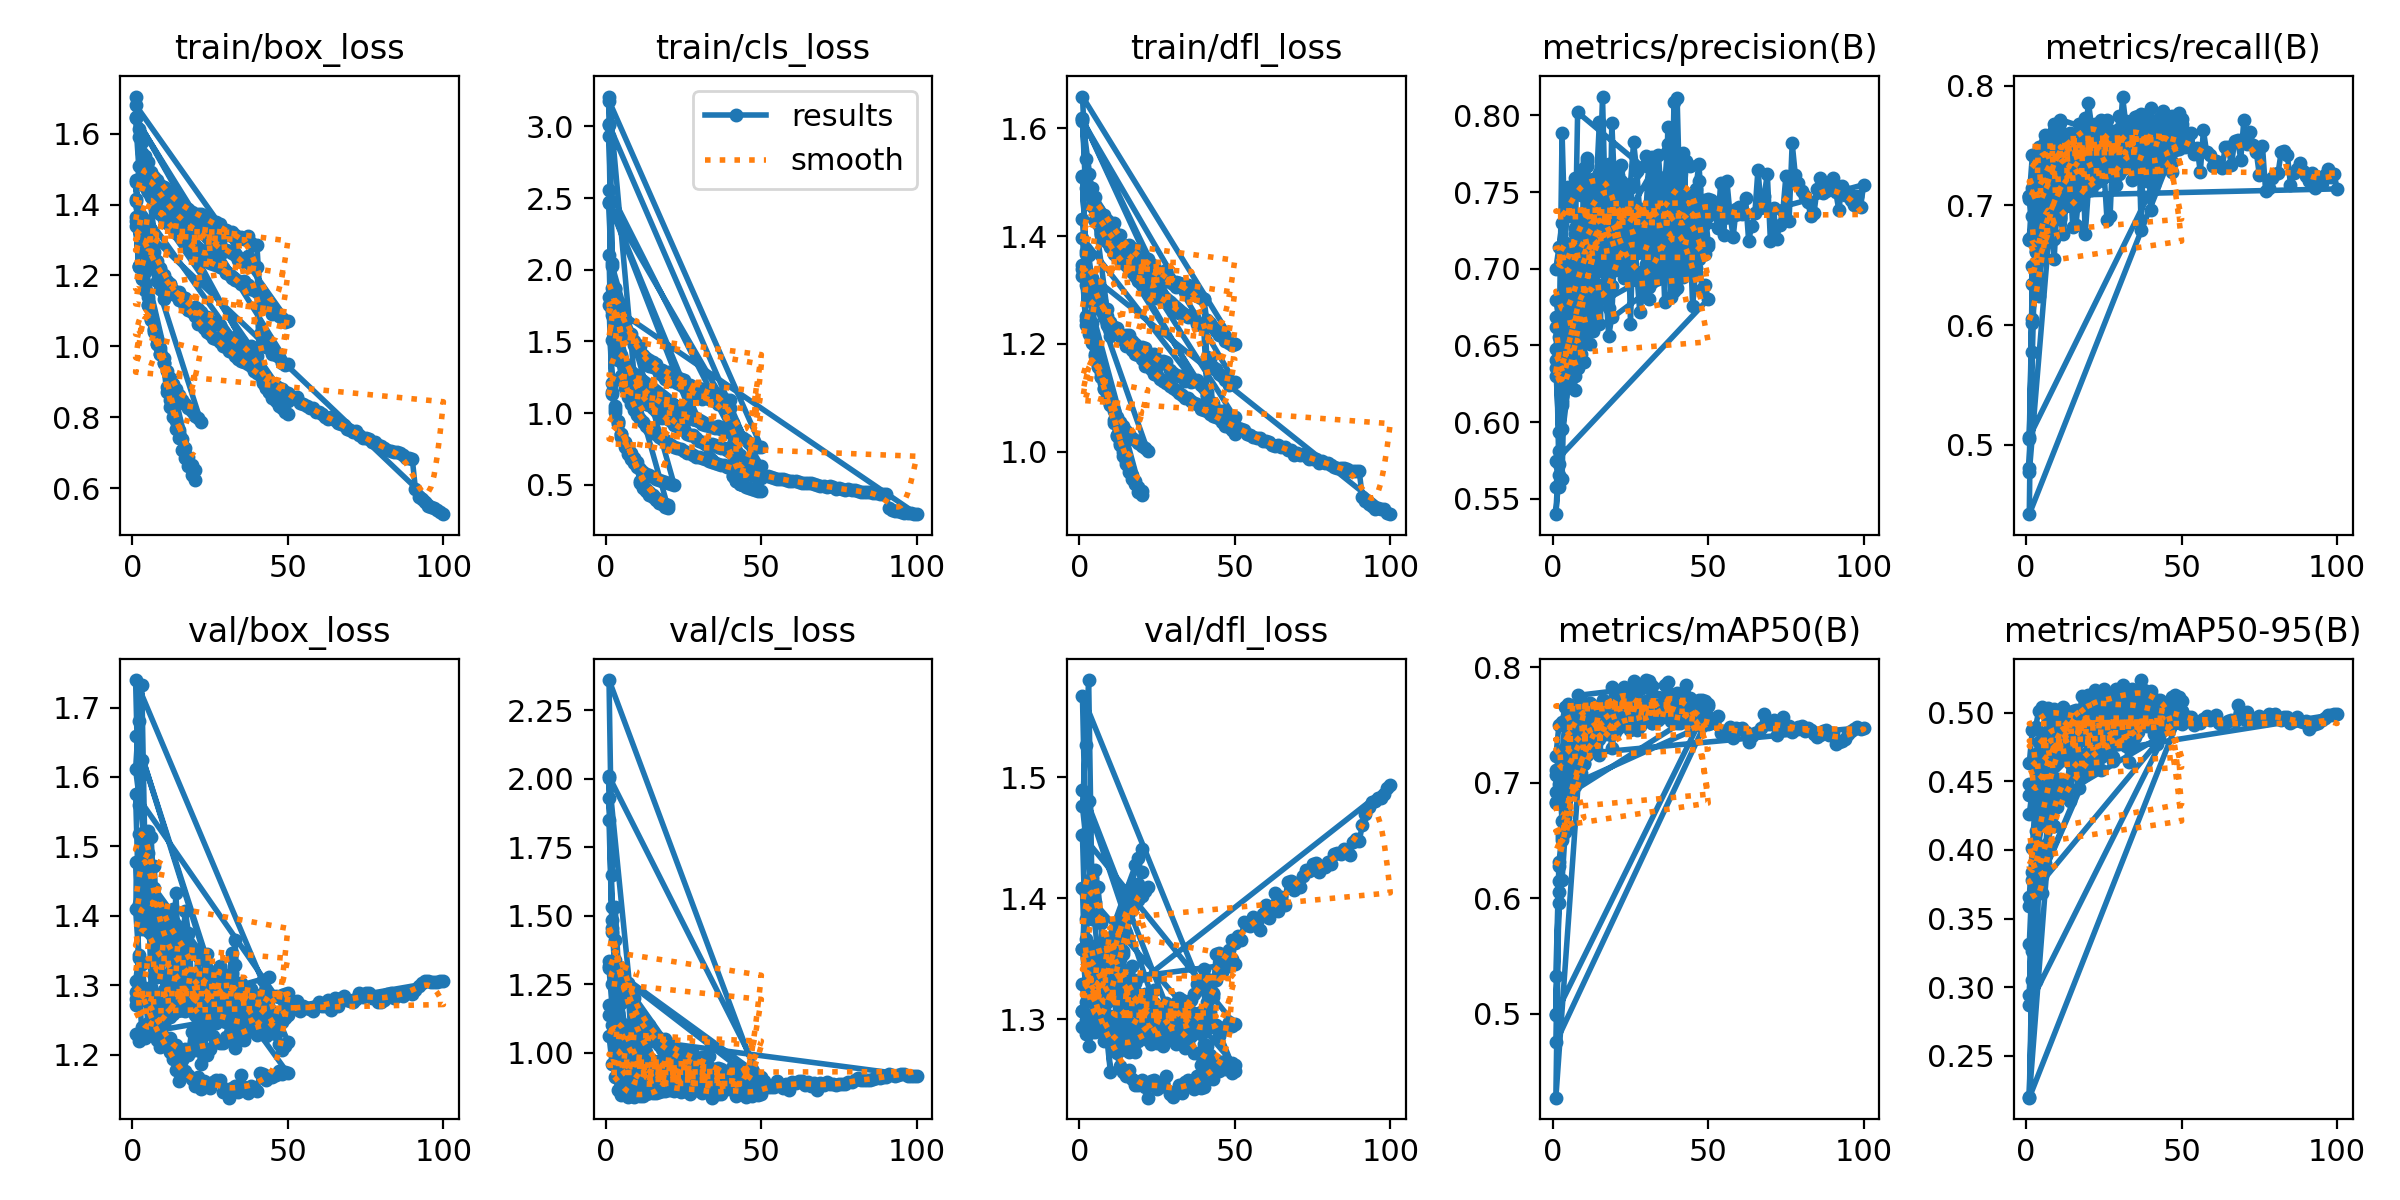

In [11]:
from IPython.display import Image, display

# Pad naar de trainingsmap
results_img = "/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/results.png"

# Toon de loss/mAP grafiek
display(Image(filename=results_img))


In [12]:
# Laad het getrainde model
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs/clothing_model/weights/best.pt")

# # Voorspellingen op testafbeeldingen
results = model.predict(
    source="/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images",  # map of enkele afbeelding
    conf=0.25,
    save=True,  # opslaan in 'runs/predict'
    save_txt=True
)



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/3432 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images/1.jpg: 640x448 1 shirt, 1 skirt, 1 bag, 1 shoe, 10.0ms
image 2/3432 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images/100247.jpg: 640x448 1 shirt, 1 skirt, 1 shoe, 8.1ms
image 3/3432 /content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split1/val/images/100247_aug0.jpg: 640x448 1 shirt, 1 dress, 2 shoes, 7.6ms
image 4/3432 /cont

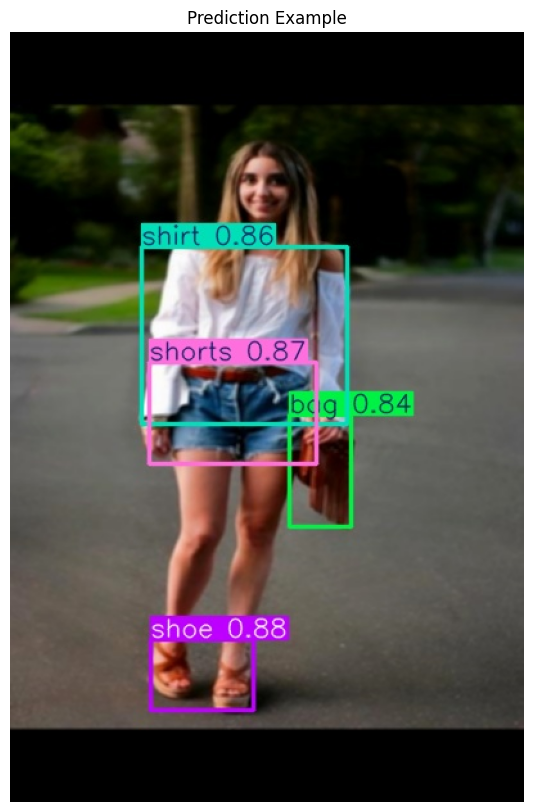

In [13]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path


# Toon een van de geplotte afbeeldingen
pred_img_path = sorted(Path("runs/detect/predict").glob("*.jpg"))[15]

img = cv2.imread(str(pred_img_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title("Prediction Example")
plt.show()


In [14]:
import os
import glob
import pandas as pd
from PIL import Image
from ultralytics import YOLO

#  Vind automatisch het meest recente YOLOv8 experiment
runs_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/split/runs'
list_of_runs = glob.glob(f'{runs_dir}/*')
if not list_of_runs:
    raise FileNotFoundError(f"Geen experimenten gevonden in {runs_dir}")

latest_run_dir = max(list_of_runs, key=os.path.getctime)
weights_path = os.path.join(latest_run_dir, 'weights/best.pt')
if not os.path.exists(weights_path):
    raise FileNotFoundError(f"Bestand niet gevonden: {weights_path}")

# Laad het YOLOv8-model
model = YOLO(weights_path)
model.eval()

# Testset pad
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/Portfolio 3 Datasets/Test/images'
submission_output_path = '/content/yolo8test3.csv'

# Predictiefunctie
def predict_model(image_path):
    results = model.predict(image_path, conf=0.25, verbose=False)

    img = Image.open(image_path)
    w_img, h_img = img.size

    preds = []
    for r in results:
        if r.boxes is not None and len(r.boxes) > 0:
            for box in r.boxes:
                cls = int(box.cls.item())
                conf = round(float(box.conf.item()), 4)

                xmin, ymin, xmax, ymax = box.xyxy[0].tolist()
                cx = (xmin + xmax) / 2 / w_img
                cy = (ymin + ymax) / 2 / h_img
                bw = (xmax - xmin) / w_img
                bh = (ymax - ymin) / h_img

                preds.extend([
                    cls,
                    conf,
                    round(cx, 6),
                    round(cy, 6),
                    round(bw, 6),
                    round(bh, 6)
                ])
    return preds

# Verwerk testafbeeldingen
all_test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
all_test_images.sort()

submission_data = {
    'id': [],
    'predictions': []
}

for img_name in all_test_images:
    img_path = os.path.join(test_images_dir, img_name)
    preds_list = predict_model(img_path)

    preds_string = ",".join([str(p) for p in preds_list])
    preds_string = f'[{preds_string}]'

    image_id = os.path.splitext(img_name)[0]
    submission_data['id'].append(image_id)
    submission_data['predictions'].append(preds_string)

# 💾 Maak CSV-bestand
df_submission = pd.DataFrame(submission_data)
df_submission.to_csv(submission_output_path, index=False)

print(f'Submission bestand opgeslagen in: {submission_output_path}')


Submission bestand opgeslagen in: /content/yolo8test3.csv


#### Bronnen:

- Murel, J., PhD, & Kavlakoglu, E. (2025, 16 april). Object Detection. IBM. https://www.ibm.com/think/topics/object-detection#:~:text=Object%20detection%20is%20a%20technique,imaging%20to%20self%2Ddriving%20cars.

- Kundu, R. (z.d.). YOLO: Algorithm for Object Detection Explained [+Examples]. V7. https://www.v7labs.com/blog/yolo-object-detection

- Mean average precision (mAP) in object detection. (2023, 12 juni). SuperAnnotate. https://www.superannotate.com/blog/mean-average-precision-and-its-uses-in-object-detection

- Boesch, G. (2025, 4 april). YOLO Explained: From v1 to Present. viso.ai. https://viso.ai/computer-vision/yolo-explained/